# Chapter 6

In [1]:
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import scipy.stats as stats
import numpy as np
import theano.tensor as tt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Exercise 1

In [2]:
# Fix this later
mu = [10,20,30]
sd = 1

vals = stats.norm.rvs(loc=mu, scale=sd, size=(100,3)).flatten()
vals[:5]

array([10.71444254, 20.08712795, 30.2414559 ,  7.6190144 , 20.58366716])

Let's plot a kde plot to see what things look like

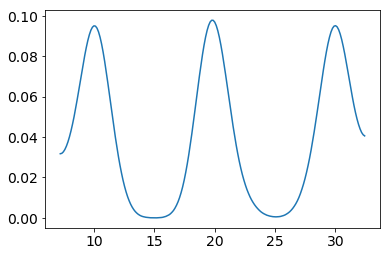

In [3]:
az.plot_kde(vals)

### Fit 2, 3, and 4 component mixture models

In [ ]:
clusters = [2,3,4]
traces = {}
for cluster in clusters:
    with pm.Model() as two_components:
        p = pm.Dirichlet("p", a=np.ones(cluster))

        # Each mean of the mixture data has its own estimate of a mean with a fixed SD in this case
        means = pm.Normal("means", mu= vals.mean(), sd=10, shape=cluster)
        
        # Estimate of the standard deviation of what?
        sd = pm.HalfCauchy("sd", 1)
        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=vals)
        
        trace = pm.sample(random_seed=123)
        traces[f"Cluster Size {cluster}"] = az.from_pymc3(trace=trace)

# Exercise 2

In [ ]:
comparison = az.compare(traces)
comparison

In [ ]:
az.loo(traces["Cluster Size 2"])

In [ ]:
az.loo(traces["Cluster Size 3"])

In [ ]:
az.loo(traces["Cluster Size 4"])

In [ ]:
az.plot_compare(comparison)

### Ask about this
When we have four chains why does the MCMC algorithm have so much trouble converging? Is it the starting points and each chain gets stuck in one? 

Alternatively asked why isn't there just an indentifiability problem?

In [ ]:
az.plot_trace(traces["Cluster Size 3"])

In [ ]:
az.plot_trace(traces["Cluster Size 4"])

## Exercise 4

In [ ]:
K=10

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [ ]:
with pm.Model() as model:
    α = pm.Gamma('α', 1, 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means',
                      mu=np.linspace(vals.min(), vals.max(), K),
                      sd=1, shape=K)
    
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=vals)
    priors = pm.sample_prior_predictive(2000)
    #trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept':0.85})